#**Assignment 1**

## Import libraries 



In [ ]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import math
import numpy
import shapely
import geopy.distance
from shapely.geometry import Point,Polygon

## Import data from Google Drive


In [ ]:
os.chdir('/content/drive/My Drive/Advanced Machine Learning /assignment1/data')
x_train=pd.read_csv('X_train.csv').iloc[:, 1:]
y_train=pd.read_csv('y_train.csv').iloc[:, 1:]
x_test=pd.read_csv('X_test.csv').iloc[:, 1:]

training_set = x_train.copy()
training_set['price']=y_train

test_set = x_test.copy()



## Exploratory analysis

In [ ]:
print(training_set.shape)
training_set.head()

(33884, 10)


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
0,40.71239,-73.95271,4,2,0.19,1,0,1,0,65
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0,57
2,40.62707,-74.02817,3,1,0.04,1,87,0,0,225
3,40.77910,-73.98565,1,4,0.08,1,0,0,1,175
4,40.75777,-73.93509,1,0,0.00,1,358,1,0,125


In [ ]:
print(test_set.shape)
test_set.head()

(3765, 9)


,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,40.68579,-73.97455,2,4,0.17,1,0,0,1
1,40.67085,-73.92316,1,9,0.61,1,0,1,0
2,40.68817,-73.91523,2,31,1.35,5,0,1,0
3,40.67201,-73.86944,3,0,0.00,2,363,1,0
4,40.68696,-73.92905,1,7,0.19,1,0,1,0


In [ ]:
training_set

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
0,40.71239,-73.95271,4,2,0.19,1,0,1,0,65
1,40696.00000,-73.91303,4,17,0.66,2,307,1,0,57
2,40.62707,-74.02817,3,1,0.04,1,87,0,0,225
3,40.77910,-73.98565,1,4,0.08,1,0,0,1,175
4,40.75777,-73.93509,1,0,0.00,1,358,1,0,125
...,...,...,...,...,...,...,...,...,...,...
33879,40.71187,-73.95864,1,0,0.00,2,0,1,0,150
33880,40.74123,-73.90152,30,0,0.00,103,247,1,0,59
33881,40.73375,-73.95570,2,3,0.23,1,0,1,0,60
33882,40.73660,-73.92358,30,1,0.19,103,252,1,0,39


* checking columns types 

In [ ]:
training_set.dtype

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
price                               int64
dtype: object

In [ ]:
test_set.dtypes

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
dtype: object

* checking missing values 

In [ ]:
training_set.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
price                             0
dtype: int64

In [ ]:
test_set.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
dtype: int64

In [ ]:
training_set.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
count,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000
mean,393.742123,-767.324528,7.109904,23.391778,1.095455,7.101080,112.995839,0.456085,0.520127,153.605389
std,3773.366411,7123.758128,20.234836,44.608022,1.610452,32.746915,131.641035,0.498075,0.499602,249.102710
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690427,-73.983503,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,69.000000
50%,40.723645,-73.956025,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,1.000000,106.000000
75%,40.763910,-73.937005,5.000000,24.000000,1.590000,2.000000,227.000000,1.000000,1.000000,175.000000
max,40894.000000,-73.712990,1000.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000,10000.000000


In [ ]:
training_set[['latitude','longitude']].min()

latitude        40.49979
longitude   -74142.00000
dtype: float64

In [ ]:
training_set[['latitude','longitude']].max()

latitude     40894.00000
longitude      -73.71299
dtype: float64

* anomaly detection 

Dalle descrittive fornite da pandas notiamo subito alcune criticità:

> `latitudine` e `longitudine` :
>>le coordinate che identificano New York City sono (40.730610,-73.935242) pertanto le coordinate delle altre abitazioni non potranno discostarsi molto da quei valori. Osserviamo che il valore massimo per la è `latitudine` 40894.0 mentre il valore minimo per la `longitudine` è -74142.0 . 
**Soluzione proposta** : una più accurata analisi ci fa notare che il separatore virgola è erroneamente spostato di 3 cifre : basterà quindi dividere tutti i valori errati per 1000.

> `price` : 
>> alcune abitazioni hanno prezzo nullo. **Soluzione proposta** : In questo caso non ha senso mantenere l'osservazione nel dataframe, perciò decidiamo di rimuoverla.



In [ ]:
def unbias(row):
  if abs(row) > 1000 :
    return row/1000.0
  else : return row

training_set['latitude']=training_set['latitude'].apply(unbias)
training_set['longitude']=training_set['longitude'].apply(unbias)


In [ ]:
training_set = training_set[training_set['price'] != 0]

In [ ]:
coordinates = [Point(xy) for xy in zip(training_set.longitude,training_set.latitude)]
training_set_new=geopandas.GeoDataFrame(training_set, geometry=coordinates,crs={'init':'epsg:4326'})
training_set_new[['latitude','longitude','geometry']].head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,latitude,longitude,geometry
0,40.71239,-73.95271,POINT (-73.95271 40.71239)
1,40.69600,-73.91303,POINT (-73.91303 40.69600)
2,40.62707,-74.02817,POINT (-74.02817 40.62707)
3,40.77910,-73.98565,POINT (-73.98565 40.77910)
4,40.75777,-73.93509,POINT (-73.93509 40.75777)


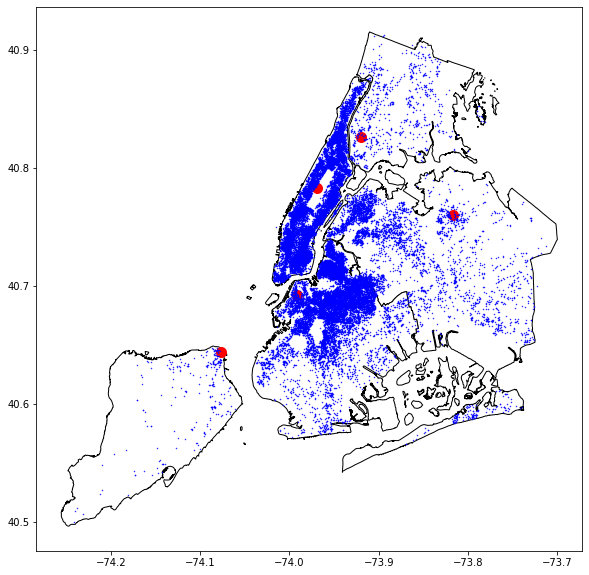

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
boroughs = geopandas.read_file(geopandas.datasets.get_path("nybb"))
boroughs_locations = geopandas.tools.geocode(boroughs.BoroName.to_list())
boroughs.to_crs("EPSG:4326").plot(ax=ax, color="white", edgecolor="black")
boroughs_locations.plot(ax=ax, color="red",markersize = 100)
training_set_new['geometry'].plot(ax=ax, color="blue",markersize = 0.2)


* Nota

> Osserviamo graficamente che la maggior parte delle abitazioni sono a Manhattan e Brooklyn 


* Svolgimento 

> Per associare un punto al proprio distretto possiamo calcolare le distanze tra il punto e i 5 distretti e considerare il distretto con distanza più piccola. 

In [ ]:
training_set_new['(lat,lon)']=training_set_new[['latitude','longitude']].apply(lambda x: tuple(x), axis=1)
training_set_new[['latitude','longitude','(lat,lon)']].head()

,latitude,longitude,"(lat,lon)"
0,40.71239,-73.95271,"(40.71239, -73.95271)"
1,40.69600,-73.91303,"(40.696, -73.91303)"
2,40.62707,-74.02817,"(40.62707, -74.02816999999997)"
3,40.77910,-73.98565,"(40.7791, -73.98565)"
4,40.75777,-73.93509,"(40.75777, -73.93509)"


In [ ]:
def extract_coords(row):
  return (tuple((row.y,row.x)))
 
boroughs_locations['(lat,lon)']= boroughs_locations['geometry'].apply(extract_coords)
boroughs_locations[['geometry','address','(lat,lon)']].head()

,geometry,address,"(lat,lon)"
0,POINT (-74.07620 40.64350),"Staten Island, NY, United States","(40.6434974670665, -74.0762023925121)"
1,POINT (-73.81730 40.75978),"Queens County, United States","(40.7597770690667, -73.8172988891209)"
2,POINT (-73.99100 40.69253),"Brooklyn, NY, United States","(40.6925277709666, -73.9909973144121)"
3,POINT (-73.96943 40.78303),"Manhattan, New York, United States","(40.7830276489668, -73.9694290161121)"
4,POINT (-73.92027 40.82615),"Bronx County, United States","(40.8261528015668, -73.9202651977121)"


In [ ]:
def distance(row):
  districts = {'staten island':0,'queens':1, 'brooklyn': 2, 'manhattan':3, 'bronx': 4} 
  min_dist = 10000000 
  min_district=''
  for district in districts:
    dist = geopy.distance.geodesic(row,boroughs_locations['(lat,lon)'].iloc[districts[district]]).kilometers
    if dist <= min_dist : 
      min_dist = dist
      min_district = districts[district]
  return min_district

training_set_new['district']= training_set_new['(lat,lon)'].apply(distance)



In [ ]:
training_set_2=training_set_new[['district','minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Private_room', 'Entire_home/apt', 'price']]
training_set_2.head()

,district,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
0,2,4,2,0.19,1,0,1,0,65
1,2,4,17,0.66,2,307,1,0,57
2,0,3,1,0.04,1,87,0,0,225
3,3,1,4,0.08,1,0,0,1,175
4,3,1,0,0.00,1,358,1,0,125


> Troviamo confermata la numerosità delle abitazioni distribuite nei quartieri di New York con quanto osservato graficamente.


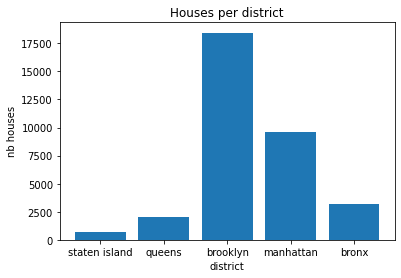

In [ ]:
plt.bar(['staten island','queens', 'brooklyn', 'manhattan', 'bronx'],list(training_set_2.groupby('district').size()))
plt.xlabel('district')
plt.ylabel('nb houses')
plt.title('Houses per district')
plt.show()

## correlazioni 






In [ ]:
#fig, ax = plt.subplots(figsize=(7,7))  
#sns.heatmap(round(training_set.corr(),3),annot=True, cmap="YlGnBu",ax=ax)